In [ ]:
import os
import re
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pytorch_lightning as pl
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# RSNA Dataset Definition
class RSNADataset(Dataset):
    def __init__(self, labels_path, patient_dir, transform=None, k=1):
        """
        k = number of neighbor slices on each side (k=1 -> seq_len = 3).
        Uses the three windowed PNGs per slice (brain, subdural, bone)
        as the 3-channel input per time step.
        """
        df = pd.read_csv(labels_path)
        self.transform = transform
        self.k = k
        self.seq_len = 2 * k + 1

        id2info = {}
        for pid in os.listdir(patient_dir):
            pid_folder = os.path.join(patient_dir, pid)
            if not os.path.isdir(pid_folder):
                continue
            for fname in os.listdir(pid_folder):
                if not fname.lower().endswith('_brain.png'):
                    continue
                m = re.match(r'^(?P<prefix>\d+_)(?P<id>ID_[0-9a-f]+)_brain\.png$', fname, flags=re.IGNORECASE)
                if not m:
                    continue
                prefix   = m.group('prefix')               # e.g. "0001_"
                image_id = m.group('id')                   # e.g. "ID_ab12cd34"
                slice_idx = int(prefix[:-1])
                id2info[image_id] = (pid_folder, slice_idx, prefix)

        df = df[df.ImageID.isin(id2info)].reset_index(drop=True)
        if df.empty:
            raise RuntimeError("No matching windowed PNGs found for any ImageID in CSV.")

        df['patient_folder'] = df.ImageID.map(lambda i: id2info[i][0])
        df['slice_index']    = df.ImageID.map(lambda i: id2info[i][1])
        df['prefix']         = df.ImageID.map(lambda i: id2info[i][2])

        # sort by patient then slice
        self.df = df.sort_values(['patient_folder','slice_index']).reset_index(drop=True)
        self.label_cols = ['epidural', 'intraparenchymal', 'intraventricular',
                           'subarachnoid', 'subdural']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pid_folder = row.patient_folder
        center_si  = row.slice_index
        prefix     = row.prefix
        image_id   = row.ImageID

        # gather all slices for this patient
        scan_df = self.df[self.df.patient_folder == pid_folder].reset_index(drop=True)
        pos = scan_df[scan_df.slice_index == center_si].index.item()

        imgs = []
        for offset in range(-self.k, self.k+1):
            pos2 = max(0, min(pos + offset, len(scan_df)-1))
            row2 = scan_df.iloc[pos2]
            pf    = row2.patient_folder
            pr    = row2.prefix
            imgid = row2.ImageID

            # load each window as one channel
            channels = []
            for win in ['brain', 'subdural', 'bone']:
                fname = f"{pr}{imgid}_{win}.png"
                fpath = os.path.join(pf, fname)
                im = Image.open(fpath).convert('L')
                if self.transform:
                    im = self.transform(im)   # shape: (1, H, W)
                channels.append(im)
            # concatenate the three windowed channels (3, H, W)
            imgs.append(torch.cat(channels, dim=0))

        # stack along sequence dimension (seq_len, 3, H, W)
        x = torch.stack(imgs, dim=0)
        y = row[self.label_cols].values.astype(np.float32)
        return x, torch.from_numpy(y)

In [ ]:
# LightningModule with LSTM Aggregation
class EfficientNetLSTM(pl.LightningModule):
    def __init__(self, num_labels, lr=1e-4, hidden_dim=256, lstm_layers=1, bidirectional=False):
        super().__init__()
        self.save_hyperparameters()

        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        feat_dim = self.backbone._fc.in_features
        # Remove head
        self.backbone._fc = nn.Identity()
        self.backbone._dropout = nn.Identity()

        # LSTM for sequence of features
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=self.hparams.hidden_dim,
            num_layers=self.hparams.lstm_layers,
            batch_first=True,
            bidirectional=self.hparams.bidirectional
        )
        lstm_out_dim = self.hparams.hidden_dim * (2 if self.hparams.bidirectional else 1)

        self.classifier = nn.Linear(lstm_out_dim, num_labels)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x):
        # x: (B, seq_len, C, H, W)
        B, S, C, H, W = x.shape
        x = x.view(B * S, C, H, W)
        feats = self.backbone.extract_features(x)
        feats = self.backbone._avg_pooling(feats)
        feats = feats.flatten(1)
        feats = feats.view(B, S, -1)

        outputs, (hn, cn) = self.lstm(feats)
        final_h = hn[-1] if not self.hparams.bidirectional else torch.cat((hn[-2], hn[-1]), dim=1)
        logits = self.classifier(final_h)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.log('val_loss', loss, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# Prepare Dataset & DataLoaders
CSV_PATH    = 'labels.csv'
PATIENT_DIR = 'patient_images_0_1000'
k_neighbors = 1
batch_size  = 16
lr          = 1e-4
max_epochs  = 10

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = RSNADataset(CSV_PATH, PATIENT_DIR, transform=train_transform, k=k_neighbors)
print(f"Total slices: {len(dataset)}")

# Split 70/15/15
total = len(dataset)
train_size = int(0.70 * total)
val_size   = int(0.15 * total)
test_size  = total - train_size - val_size

generator = torch.Generator().manual_seed(seed)
train_ds, val_ds, test_ds = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=generator
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

Total slices: 50863


In [ ]:
# Count of each hemorrhage type in the full dataset
label_cols = dataset.label_cols
counts = dataset.df[label_cols].sum().astype(int)

print("Number of slices with each hemorrhage type:")
for lbl, cnt in counts.items():
    print(f"  {lbl:17s}: {cnt}")

Number of slices with each hemorrhage type:
  epidural         : 240
  intraparenchymal : 2853
  intraventricular : 1962
  subarachnoid     : 2627
  subdural         : 3180


In [ ]:
# Train Model
num_labels = len(dataset.label_cols)
model = EfficientNetLSTM(num_labels=num_labels, lr=lr, hidden_dim=256)
trainer = pl.Trainer(max_epochs=max_epochs, accelerator='mps')
trainer.fit(model, train_loader, val_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b0


/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | backbone   | EfficientNet      | 4.0 M  | train
1 | lstm       | LSTM              | 1.6 M  | train
2 | classifier | Linear            | 1.3 K  | train
3 | loss_fn    | BCEWithLogitsLoss | 0      | train
---------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.335    Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Grid-Search Thresholds on Validation Set
device = next(model.parameters()).device
model.eval()

all_probs_val, all_labels_val = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)).cpu().numpy()
        all_probs_val.append(probs)
        all_labels_val.append(yb.numpy())
probs_val  = np.vstack(all_probs_val)
labels_val = np.vstack(all_labels_val)

label_names = dataset.label_cols
opt_thresholds = {}
for i, name in enumerate(label_names):
    best_t, best_f1 = 0.5, 0.0
    for t in np.linspace(0,1,101):
        preds = (probs_val[:, i] >= t).astype(int)
        f1    = f1_score(labels_val[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    opt_thresholds[name] = best_t
    print(f"{name:15s} → best threshold = {best_t:.2f}   (F1 = {best_f1:.4f})")

epidural        → best threshold = 0.74   (F1 = 0.7857)
intraparenchymal → best threshold = 0.31   (F1 = 0.8270)
intraventricular → best threshold = 0.27   (F1 = 0.8000)
subarachnoid    → best threshold = 0.49   (F1 = 0.7804)
subdural        → best threshold = 0.59   (F1 = 0.8427)


In [ ]:
# Final Evaluation on Test Set
all_probs_test, all_labels_test = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        probs = torch.sigmoid(model(xb)).cpu().numpy()
        all_probs_test.append(probs)
        all_labels_test.append(yb.numpy())
probs_test  = np.vstack(all_probs_test)
labels_test = np.vstack(all_labels_test)

thresh_arr = np.array([opt_thresholds[n] for n in label_names])
preds_test = (probs_test >= thresh_arr).astype(int)
print("\nTest set performance:")
for i, name in enumerate(label_names):
    f1 = f1_score(labels_test[:,i], preds_test[:,i], zero_division=0)
    print(f"  {name:15s} F1 = {f1:.4f}")

micro_f1 = f1_score(labels_test, preds_test, average='micro', zero_division=0)
macro_f1 = f1_score(labels_test, preds_test, average='macro', zero_division=0)
print(f"\n  Micro-averaged F1: {micro_f1:.4f}")
print(f"  Macro-averaged F1: {macro_f1:.4f}")


Test set performance:
  epidural        F1 = 0.7667
  intraparenchymal F1 = 0.8175
  intraventricular F1 = 0.7504
  subarachnoid    F1 = 0.7823
  subdural        F1 = 0.8428

  Micro-averaged F1: 0.8024
  Macro-averaged F1: 0.7919


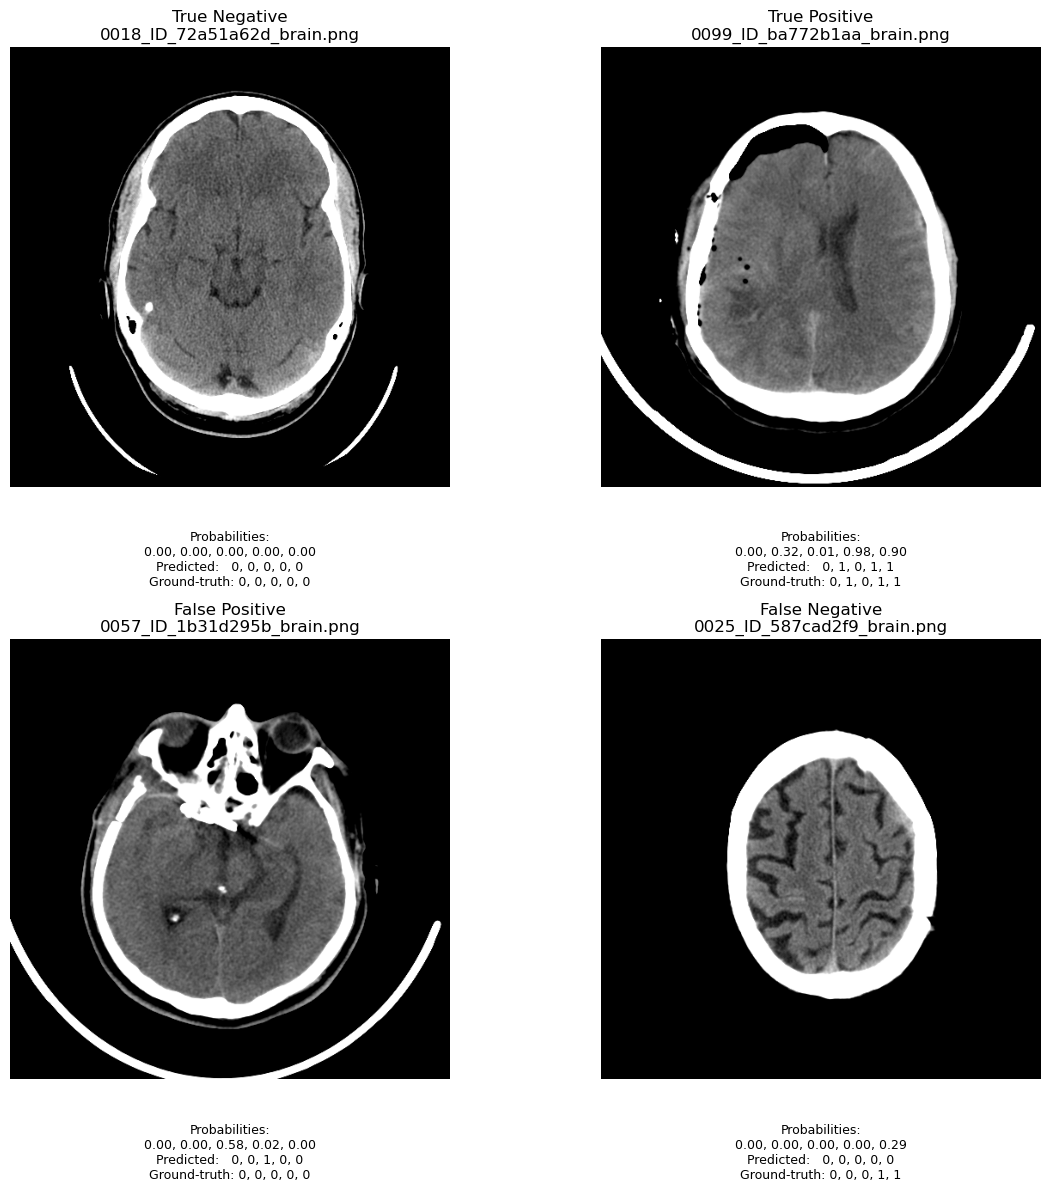

In [ ]:
# Visualize multi-label TN, TP, FP & FN examples
tn_idx = np.where((labels_test.sum(axis=1) == 0) & (preds_test.sum(axis=1) == 0))[0]
tp_idx = np.where((labels_test.sum(axis=1) > 0) & np.all(labels_test == preds_test, axis=1))[0]
fp_idx = np.where((labels_test.sum(axis=1) == 0) & (preds_test.sum(axis=1) > 0))[0]
fn_idx = np.where((labels_test.sum(axis=1) > 0) & (preds_test.sum(axis=1) == 0))[0]

cases = [
    ("True Negative", tn_idx),
    ("True Positive", tp_idx),
    ("False Positive", fp_idx),
    ("False Negative", fn_idx)
]

plt.figure(figsize=(12, 12))
for i, (case_name, idxs) in enumerate(cases, 1):
    ax = plt.subplot(2, 2, i)
    if idxs.size > 0:
        test_i = np.random.choice(idxs)
        orig_idx = test_ds.indices[test_i]
        row = dataset.df.iloc[orig_idx]
        img = Image.open(row.patient_folder + '/' + f"{row.prefix}{row.ImageID}_brain.png").convert('RGB')
        ax.imshow(img)
        ax.axis('off')

        prob_vec = probs_test[test_i]
        pred_vec = preds_test[test_i]
        true_vec = labels_test[test_i]

        filename = os.path.basename(row.patient_folder + '/' + f"{row.prefix}{row.ImageID}_brain.png")
        title = f"{case_name}\n{filename}"
        txt = (
            "Probabilities:\n" + ", ".join(f"{p:.2f}" for p in prob_vec) + "\n"
            "Predicted:   " + ", ".join(str(x) for x in pred_vec) + "\n"
            "Ground-truth: " + ", ".join(str(int(x)) for x in true_vec)
        )
        ax.set_title(title, fontsize=12)
        ax.text(0.5, -0.1, txt, transform=ax.transAxes,
                fontsize=9, va='top', ha='center')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

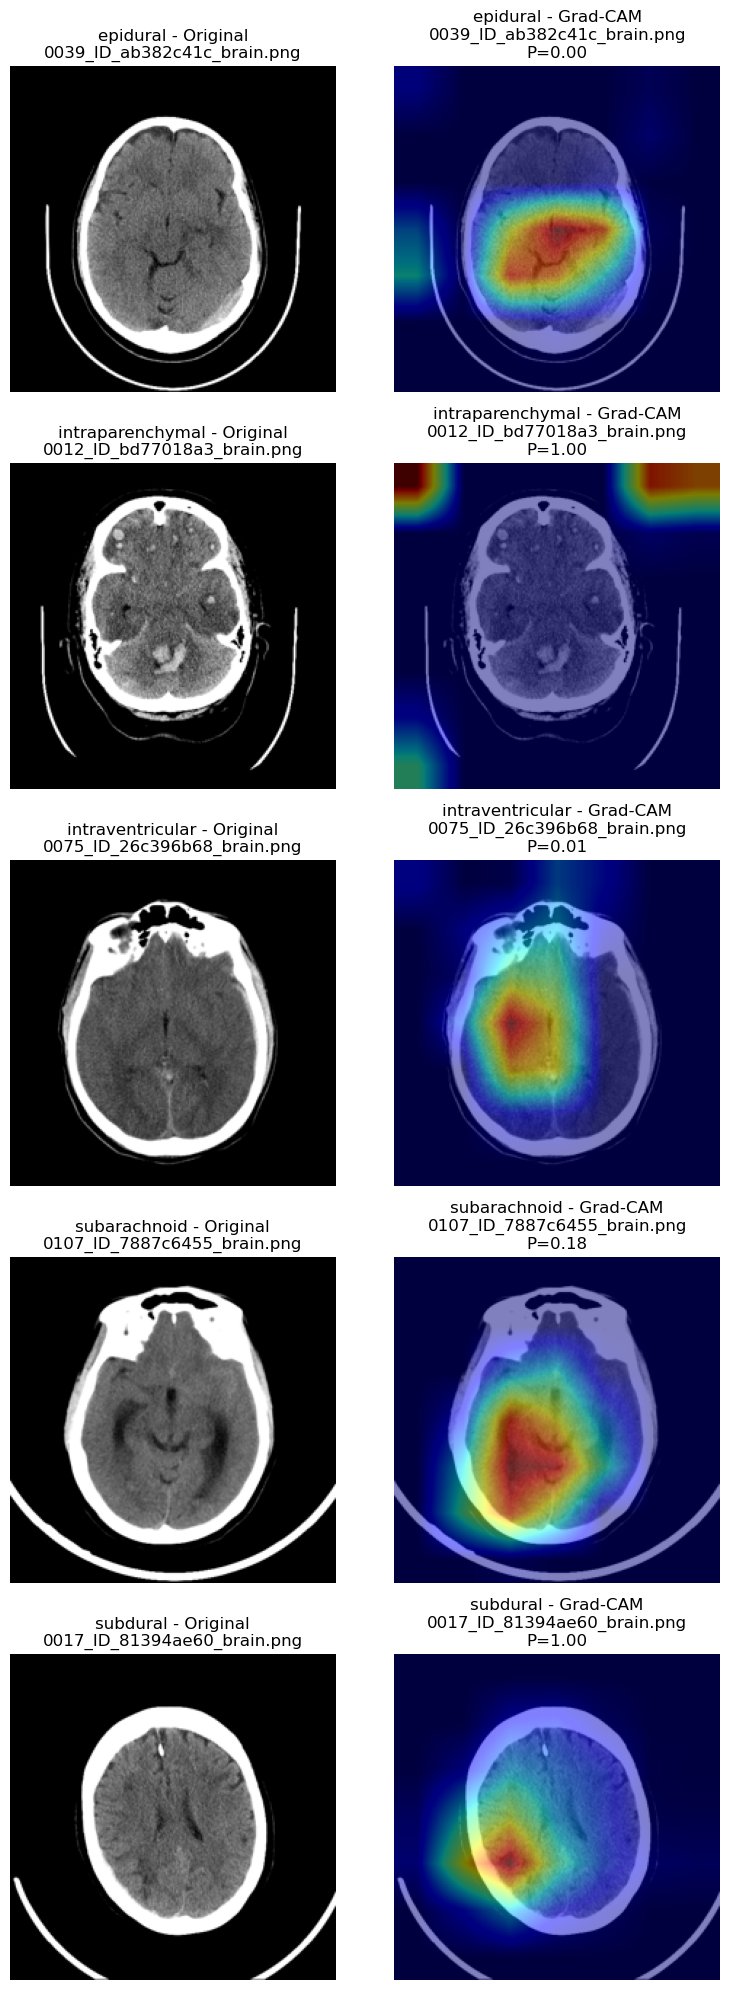

In [ ]:
# Grad-CAM – one random case per class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.target_layer.register_forward_hook(self._save_activations)
        self.target_layer.register_full_backward_hook(self._save_gradients)

    def _save_activations(self, module, inp, outp):
        self.activations = outp.detach()

    def _save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, input_tensor, class_idx):
        self.model.zero_grad()
        logits = self.model(input_tensor)
        loss = logits[:, class_idx].sum()
        loss.backward(retain_graph=True)

        grads = self.gradients[0]
        acts = self.activations[0]
        weights = grads.mean(dim=(1, 2))
        cam = (weights[:, None, None] * acts).sum(dim=0)
        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam.cpu().numpy()

# Initialize and plot
target_layer = model.backbone._conv_head
gradcam = GradCAM(model, target_layer)
device = next(model.parameters()).device

num_classes = len(label_names)
fig, axes = plt.subplots(num_classes, 2, figsize=(8, num_classes * 4))

for i, class_name in enumerate(label_names):
    pos_idxs = np.where(labels_test[:, i] == 1)[0]
    if pos_idxs.size == 0:
        axes[i,0].axis('off')
        axes[i,1].axis('off')
        continue

    chosen = np.random.choice(pos_idxs)
    orig_idx = test_ds.indices[chosen]
    row = dataset.df.iloc[orig_idx]
    # use the brain-window view for display
    img_path = os.path.join(row.patient_folder, f"{row.prefix}{row.ImageID}_brain.png")
    img = Image.open(img_path).convert('RGB').resize((224,224))
    filename = os.path.basename(img_path)

    # Original image
    ax_orig = axes[i, 0]
    ax_orig.imshow(img)
    ax_orig.set_title(f"{class_name} - Original\n{filename}")
    ax_orig.axis('off')

    # Grad-CAM overlay
    x, _ = test_ds[chosen]
    x = x.unsqueeze(0).to(device)
    cam = gradcam(x, i)
    cam_img = Image.fromarray((cam*255).astype(np.uint8)).resize((224,224), Image.BILINEAR)
    cam_np = np.array(cam_img)/255.0
    prob = probs_test[chosen, i]

    ax_cam = axes[i, 1]
    ax_cam.imshow(img)
    ax_cam.imshow(cam_np, cmap='jet', alpha=0.5)
    ax_cam.set_title(f"{class_name} - Grad-CAM\n{filename}\nP={prob:.2f}")
    ax_cam.axis('off')

plt.tight_layout()
plt.show()

/var/folders/sx/9nlnbpc53zz6kgmynpy8_1yc0000gn/T/ipykernel_86417/4113937952.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('jet')


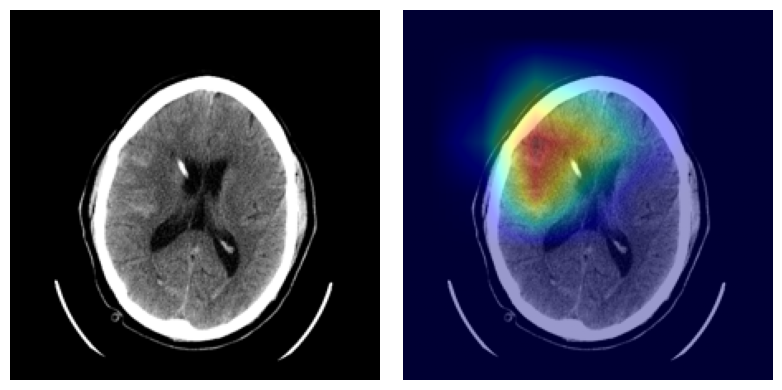

In [ ]:
# Display & save CT slice + GradCAM overlay for a given ImageID
from matplotlib import cm

image_id    = 'ID_43d8ad60a'
class_index = 3
alpha       = 0.4

mask = dataset.df['ImageID'] == image_id
if not mask.any():
    raise ValueError(f"ImageID '{image_id}' not found in dataset.df")

# load the CT slice
row           = dataset.df.loc[mask].iloc[0]
patient_folder = row.patient_folder
prefix         = row.prefix
ct_path        = os.path.join(patient_folder, f"{prefix}{image_id}_brain.png")
ct_img_pil     = Image.open(ct_path).convert('RGB').resize((224, 224))
ct_np          = np.array(ct_img_pil) / 255.0

# build input tensor and move to device
ds_idx = dataset.df.index[mask][0]
x, _   = dataset[ds_idx]
x      = x.unsqueeze(0).to(device)

# compute raw Grad-CAM mask
cam = gradcam(x, class_index) # shape: (H, W)
cam_resized = np.array(Image.fromarray((cam*255).astype(np.uint8))
                                .resize((224, 224), Image.BILINEAR)) / 255.0

# create colored heatmap (RGBA) and overlay
colormap = cm.get_cmap('jet')
heat_rgba = colormap(cam_resized) # shape: (224,224,4)
heat_rgb  = heat_rgba[..., :3]
overlay   = ct_np * (1 - alpha) + heat_rgb * alpha
overlay = np.clip(overlay, 0, 1)

# display side by side
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax0.imshow(ct_np);      ax0.axis('off')
ax1.imshow(overlay);    ax1.axis('off')
plt.tight_layout()
plt.show()

ct_img_pil.save(f"{image_id}_ct.png")
overlay_pil = Image.fromarray((overlay * 255).astype(np.uint8))
overlay_pil.save(f"{image_id}_gradcam.png")

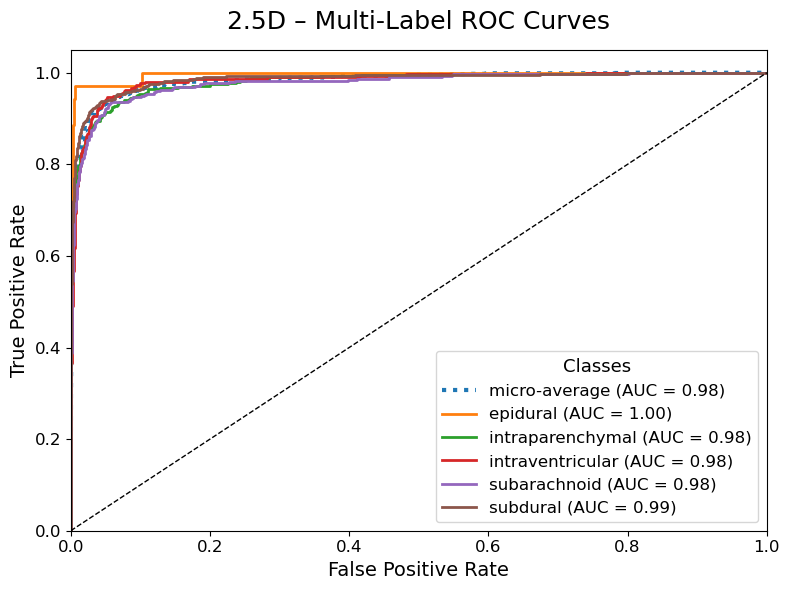

In [ ]:
# ROC-curve computation & plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, roc_auc = {}, {}, {}

for i, name in enumerate(label_names):
    if labels_test[:, i].sum() == 0:
        print(f"No positive samples for “{name}” in test set — skipping ROC.")
        continue
    
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], probs_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(labels_test.ravel(), probs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(8, 6))

# Micro-average
plt.plot(
    fpr["micro"], tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.2f})",
    linestyle=':', linewidth=3
)

# Per-class
for i, name in enumerate(label_names):
    if i not in fpr:
        continue
    plt.plot(
        fpr[i], tpr[i],
        lw=2,
        label=f"{name} (AUC = {roc_auc[i]:.2f})"
    )

# Chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.title('2.5D - Multi-Label ROC Curves', fontsize=18, pad=15)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12, title="Classes", title_fontsize=13)
plt.tight_layout()
plt.savefig('roc_curves.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Test‐set size & confusion‐summary: TP, TN, FP, FN
num_test_samples = labels_test.shape[0]
print(f"Number of images in test set: {num_test_samples}\n")

# Boolean masks
tp_mask = (preds_test == 1) & (labels_test == 1)
tn_mask = (preds_test == 0) & (labels_test == 0)
fp_mask = (preds_test == 1) & (labels_test == 0)
fn_mask = (preds_test == 0) & (labels_test == 1)

total_tp = int(tp_mask.sum())
total_tn = int(tn_mask.sum())
total_fp = int(fp_mask.sum())
total_fn = int(fn_mask.sum())

print(f"Total true positives : {total_tp}")
print(f"Total true negatives : {total_tn}")
print(f"Total false positives: {total_fp}")
print(f"Total false negatives: {total_fn}\n")

print("Per-class breakdown:")
for i, name in enumerate(label_names):
    tp_i = int(tp_mask[:, i].sum())
    tn_i = int(tn_mask[:, i].sum())
    fp_i = int(fp_mask[:, i].sum())
    fn_i = int(fn_mask[:, i].sum())
    print(f"  {name:15s} TP = {tp_i:4d}   TN = {tn_i:6d}   FP = {fp_i:4d}   FN = {fn_i:4d}")

Number of images in test set: 7630

Total true positives : 1289
Total true negatives : 36226
Total false positives: 289
Total false negatives: 346

Per-class breakdown:
  epidural        TP =   23   TN =   7593   FP =    2   FN =   12
  intraparenchymal TP =  336   TN =   7144   FP =   57   FN =   93
  intraventricular TP =  236   TN =   7237   FP =   95   FN =   62
  subarachnoid    TP =  300   TN =   7163   FP =   73   FN =   94
  subdural        TP =  394   TN =   7089   FP =   62   FN =   85


In [ ]:
# Image-level perfect-classification count
perfect_mask = np.all(preds_test == labels_test, axis=1)

num_perfect = int(perfect_mask.sum())
num_images  = labels_test.shape[0]
pct_perfect = num_perfect / num_images * 100

print(f"Images perfectly classified across all {labels_test.shape[1]} labels: {num_perfect} / {num_images} "
      f"({pct_perfect:.1f}%)")

Images perfectly classified across all 5 labels: 7073 / 7630 (92.7%)
